## LIB IMPORT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import networkx as nx
import Utilities
import copy as cp
import scipy.stats as stats
from pathlib import Path

## FILE IMPORT

In [ ]:
# Get the current working directory
current_dir = Path.cwd()
# Get the parent directory
parent_dir = current_dir.parent

In [ ]:
#UTILITIES IMPORT
UTILITIES_PATH = parent_dir + "/UTILITIES/"
with open(UTILITIES_PATH + "subjNames.txt", "r") as f:
    subjNames = f.read().splitlines()
with open(UTILITIES_PATH + "problemList.txt", "r") as f:
    problemList = f.read().splitlines()

#GRAPHS IMPORT
MAPS_PATH = parent_dir + "/MAPS/"
#import all the graphs at once
graphLs = [Utilities.map_load(MAPS_PATH + problem[:-5]) for problem in problemList]

## FUNCTION

In [3]:
def getIntegers(number):
    #Get the two integers closest to the number
    int1 = int(number)
    int2 = int(number) + 1
    return int1, int2

def getVertices(coord):
    x, y = coord
    #Get the vertices of the rectangle that contains the point
    x1, x2 = getIntegers(x)
    y1, y2 = getIntegers(y)
    #Get the four closest nodes
    vertices = [(x1, y1), (x1, y2), (x2, y2), (x2, y1)]
    return vertices


def getSegments(vertices):
    #Get the segments of the rectangle
    segments = []
    for i in range(4):
        j = (i+1)%4
        segments.append((vertices[i], vertices[j]))
    return segments


def getClosestNode(coord):
    x, y = coord
    #Round the coordinates to the closest integers
    x = int(round(x))
    y = int(round(y))
    return (x, y)


def getClosestSegment(coord, segments):
    #Get the coordinates of the point
    x, y = coord
    segments = [np.array(segment) for segment in segments]
    distance = [np.abs(segments[0][0][0] - x), np.abs(segments[1][0][1] - y), np.abs(segments[2][0][0] - x), np.abs(segments[3][0][1] - y)]
    minIndex = np.argmin(distance)
    return segments[minIndex]


def getShortestPathLinks(g, coord1, coord2):
    #Get the closest nodes to the coordinates
    node1 = getClosestNode(coord1)
    node2 = getClosestNode(coord2)
    #Get the shortest path between the nodes
    try:
        path = nx.shortest_path(g, source=node1, target=node2)
    except:
        path = []
    #Return the sequence of links that connect the nodes
    links = [(path[i], path[i+1]) for i in range(len(path)-1)]
    return links

def getProjectionOnSegment(coord, segment):
    #Get the coordinates of the point
    x, y = coord
    #Get the coordinates of the segment
    x1, y1 = segment[0]
    x2, y2 = segment[1]
    #Compute the projection of the point on the segment
    if x1 == x2:
        x_proj = x1
        y_proj = y
    elif y1 == y2:
        x_proj = x
        y_proj = y1
    return (x_proj, y_proj)

def correctionToManhattanDistance(link, closestSegment, closestNode, projection):

    if closestSegment[0] in link and closestSegment[1] in link:
        #If the closest segment is the link return difference between the projection and the closest node
        return -(np.abs(projection[0] - closestNode[0]) + np.abs(projection[1] - closestNode[1]))
    else:
        #If the closest segment is not the link return the distance between the closest node and the projection
        return np.abs(projection[0] - closestNode[0]) + np.abs(projection[1] - closestNode[1])
    
def interpolateTrajectory(x, y, t):
    xInt = interp1d(t, x, kind='linear')
    yInt = interp1d(t, y, kind='linear')
    return xInt, yInt

## AFTER FIXATION

In [ ]:
timeLs = []
distanceLs = []
derivativeLs = []

for subjName in subjNames[:]:
    print("SUBJNAME: ", subjName)
    df = pd.read_csv(f"./OUTPUT/{subjName}dfSampleVis.csv", low_memory=False)
    dfSubj = pd.read_csv(f"./OUTPUT/{subjName}dfTrajectoryVisResampledV2.csv", low_memory=False)
    trialIndexLs = []
    touchMask = df.TYPE == "TOUCH"
    fixMask = df.TYPE == "FIX"

    movementMask = df.BEFORE_MOVEMENT == False
    noBacktrackingMask = df.BACKTRACK == False
    noPauseMask = df.PAUSE == False
    noMissinTouchMask = df.MISSING_TOUCH == False

    for TRIAL_INDEX in range(94):
        print("TRIAL_INDEX: ", TRIAL_INDEX)
        projectedX , projectedY = [], []
        trialMask = df.TRIAL_INDEX == TRIAL_INDEX
        MAPNAME = df.loc[trialMask, "MAPNAME"].values[0]
        g = graphLs[problemList.index(MAPNAME+".json")]

        distanceTrial = []
        for LABEL_FIX in dfSubj.loc[(dfSubj.TRIAL_INDEX == TRIAL_INDEX) & (dfSubj.relMotif == "N") & noBacktrackingMask & noPauseMask & noMissinTouchMask, "LABEL_FIX"].unique():
            flag = 0
            #In this case we are only considering the fixations when a simple motif is perfomed and no "patologies" are present
            print("LABEL_FIX: ", LABEL_FIX)
            labelFixMask = df[trialMask].LABEL_FIX == LABEL_FIX
            #if LABEL_FIX is nan skipt it
            if np.isnan(LABEL_FIX):
                continue
            
            ### 1. EXTRACT HAND AND EYE TRAJECTORY ###
            #Get the start and end time of the fixation
            fixStart, fixEnd = df.loc[labelFixMask & trialMask, 't'].values[0], df.loc[labelFixMask & trialMask, 't'].values[-1]
            timeMask = (df.loc[trialMask, 't'] >= fixStart-0) & (df.loc[trialMask, 't'] <= fixEnd)   

            #Select the trajecotory of the mouse during the fixation
            dfTouch = df[trialMask & touchMask & timeMask].reset_index(drop=False)
            #Shift the time to start from 0
            tTouch = dfTouch["t"] - dfTouch["t"].values[0] 
            tTouch = tTouch.values  
            xTouch = dfTouch["x"].values
            yTouch = dfTouch["y"].values
            #Interpolate the x and y coordinates of touch
            fTouchX, fTouchY = interpolateTrajectory(xTouch, yTouch, tTouch)

            #Select the trajectory of the eye during the fixation
            dfFix = df[trialMask & fixMask & timeMask].reset_index(drop=False)
            #Subtract the first time to all the times
            tFix = dfFix["t"] - dfFix["t"].values[0]
            tFix = tFix.values
            xFix = dfFix["x"].values
            yFix = dfFix["y"].values

            #Interpolate the x and y coordinates of fixations
            fFixX, fFixY = interpolateTrajectory(xFix, yFix, tFix)

            #Take ten points in the shared temporal interval
            intervalStart = max(tFix.min(), tTouch.min())
            intervalEnd = min(tFix.max(), tTouch.max())
            tnew = np.arange(intervalStart, intervalEnd, 10)
            
            #if len(tnew) < 10: #??
            #    continue
            #Map coordinates to the graph
            trajectoryTouch = Utilities.screenToMapGraph(MAPNAME, list(zip(fTouchX(tnew), fTouchY(tnew))))
            trajectoryFix = Utilities.screenToMapGraph(MAPNAME, list(zip(fFixX(tnew), fFixY(tnew))))
           
            
            Xt = [x[0] for x in trajectoryTouch]
            Yt = [x[1] for x in trajectoryTouch]
            Xe = [x[0] for x in trajectoryFix]
            Ye = [x[1] for x in trajectoryFix]

            #### 2. COMPUTE THE (CORRECTED) MANHATTAN DISTANCE ####
            #Make a copy of the graph
            g = cp.deepcopy(graphLs[problemList.index(MAPNAME+".json")])
            #ActiveNode during the fixation
            activeNodes = Utilities.parse_string(df[trialMask & (df.t<fixStart)].activeNode.values[-1])[:-1]
            #Remove the active nodes from the graph
            g.remove_nodes_from(activeNodes)
            #print("ACTIVE NODES: ", activeNodes)
            distanceTrial = []
            for xt, yt, xe, ye in zip(Xt, Yt, Xe, Ye):
                segmentsT = getSegments(getVertices((xt, yt)))
                segmentsE = getSegments(getVertices((xe, ye)))
                closestNodeT = getClosestNode((xt, yt))
                closestNodeE = getClosestNode((xe, ye))
                closestSegmentT = [tuple(n) for n in getClosestSegment((xt, yt), segmentsT)]
                closestSegmentE = [tuple(n) for n in getClosestSegment((xe, ye), segmentsE)]
                if closestNodeE not in g.nodes or closestNodeT not in g.nodes:
                    flag = 1
                    break
                projectionT = getProjectionOnSegment((xt, yt), closestSegmentT)
                projectionE = getProjectionOnSegment((xe, ye), closestSegmentE)
                shortestLinks = getShortestPathLinks(g, closestNodeT, closestNodeE)
                #print("CLOSEST NODES: ", closestNodeT, closestNodeE)
                #print("shortestLinks: ", shortestLinks)

                if len(shortestLinks) == 0:
                    #print("\n\nSAME CLOSEST NODE")
                    #print("CLOSEST NODES: ", closestNodeT, closestNodeE)
                    #print("shortestLinks: ", shortestLinks)
                    distanceT = np.abs(projectionT[0] - closestNodeT[0]) + np.abs(projectionT[1] - closestNodeT[1])
                    distanceE = np.abs(projectionE[0] - closestNodeE[0]) + np.abs(projectionE[1] - closestNodeE[1])
                    #If in the same segments the distance is the abs of the difference else is the  sum of the abs 
                    if closestSegmentT[0] in closestSegmentE and closestSegmentT[1] in closestSegmentE:
                        distance = np.abs(projectionT[0] - projectionE[0]) + np.abs(projectionT[1] - projectionE[1])
                    else:  
                        distance = distanceT + distanceE
                    distanceTrial.append(distance)
                    projectedX.append(projectionT[0])
                    projectedY.append(projectionT[1])
                    
                else:

                    #print("\n\nDIFFERENT CLOSEST NODE")
                    correctionT = correctionToManhattanDistance(shortestLinks[0], closestSegmentT, closestNodeT, projectionT)
                    correctionE = correctionToManhattanDistance(shortestLinks[0], closestSegmentE, closestNodeE, projectionE)
                    distance = len(shortestLinks) + correctionT + correctionE
                    
                    distanceTrial.append(distance)
                    projectedX.append(projectionT[0])
                    projectedY.append(projectionT[1])
                    
            
            if flag == 1:
                flag = 0
                continue
            #print("     python  StandAloneVisualization.py \"PRIVATE\" " + str(TRIAL_INDEX) + " \"" +str(subjName)+ "\" " + str(max(0, fixStart -0)) + " "   +str(fixEnd + 0))
            
            #### 3. RESAMPLING ####
            #Center the peak in 0
            time_vector = np.array(tnew)
            time_vector -= time_vector.min()
            time_vector = time_vector/time_vector.max()
            spline = UnivariateSpline(time_vector, distanceTrial, k=1, s=1)
            #Define a new time vector for resampling
            tnew2 = np.linspace(0, 1, 100) #np.linspace(time_vector.min(), time_vector.max(), num=40)#
            # Resample the curve
            distanceTrialResampled = spline(tnew2)
            #Normalize distance by the max distance
            distanceTrialResampled = distanceTrialResampled/np.max(distanceTrialResampled)

            #Compute the derivative
            derivative = np.gradient(distanceTrialResampled, tnew2)

            timeLs.append(tnew2)
            distanceLs.append(distanceTrialResampled)
            derivativeLs.append(derivative)

            trialIndexLs.append(TRIAL_INDEX)
            #distanceTrial = []
            flag = 0
            #break


In [ ]:
#Save the data
"""np.save("./timeLs.npy", timeLs)
np.save("./distanceLs.npy", distanceLs)
np.save("./derivativeLs.npy", derivativeLs)"""

In [ ]:
#Load the data
timeLsP = np.load("./timeLs.npy", allow_pickle=True)
distanceLsP = np.load("./distanceLs.npy", allow_pickle=True)
derivativeLsP = np.load("./derivativeLs.npy", allow_pickle=True)

In [589]:
#For each time compute a t-test of derivative with 0
tTest = []
pValues = []
for i in range(len(timeLsP[0])):
    t, p = stats.ttest_1samp(np.array(derivativeLsP)[:,i], 0)
    tTest.append(t)
    pValues.append(p)
#Save the results
np.save("./tTest.npy", tTest)
np.save("./pValues.npy", pValues)

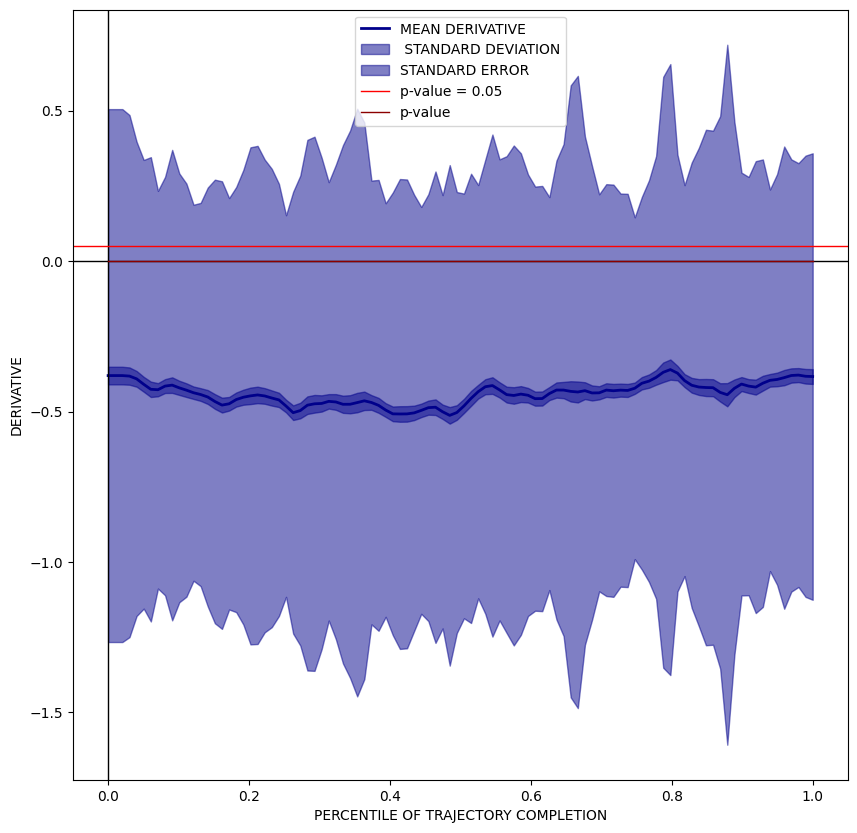

In [615]:
#Compute the meanDerivative
meanDerivative = np.mean(derivativeLsP, axis=0)
stdDerivative = np.std(derivativeLsP, axis=0)
semDerivative = np.std(derivativeLsP, axis=0)/np.sqrt(len(derivativeLsP))
#Plot the meanDerivative
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(timeLsP[0], meanDerivative, color="darkblue", linewidth=2, label = "MEAN DERIVATIVE")
ax.fill_between(timeLsP[0], meanDerivative-stdDerivative, meanDerivative+stdDerivative, color="darkblue", alpha=0.5, label = " STANDARD DEVIATION")
ax.fill_between(timeLsP[0], meanDerivative-semDerivative, meanDerivative+semDerivative, color="darkblue", alpha=0.5, label = "STANDARD ERROR")
#Draw the axis
ax.axhline(0, color="black", linewidth=1)
ax.axvline(0, color="black", linewidth=1)
#Plot the p-values
plt.axhline(0.05, color="red", linewidth=1, label = "p-value = 0.05")
plt.plot(timeLsP[0], pValues, color="darkred", linewidth=1, label = "p-value")
plt.legend(loc = "upper center")
plt.xlabel("PERCENTILE OF TRAJECTORY COMPLETION")
plt.ylabel("DERIVATIVE")
#save the plot
#plt.savefig("./OUTPUT/DERIVATIVE_PLOT.png")
plt.show()

## BEFORE FIXATION

In [ ]:
timeLs = []
distanceLs = []
derivativeLs = []

for subjName in subjNames[:]:
    print("SUBJNAME: ", subjName)
    df = pd.read_csv(parent_dir + f"/COARTICULATION/OUTPUT/{subjName}dfSampleVis.csv", low_memory=False)
    dfSubj = pd.read_csv(parent_dir + f"COARTICULATION/OUTPUT/{subjName}dfTrajectoryVisResampledV2.csv", low_memory=False)
    #trialIndexLs = []
    touchMask = df.TYPE == "TOUCH"
    fixMask = df.TYPE == "FIX"

    movementMask = df.BEFORE_MOVEMENT == False
    noBacktrackingMask = df.BACKTRACK == False
    noPauseMask = df.PAUSE == False
    noMissinTouchMask = df.MISSING_TOUCH == False

    for TRIAL_INDEX in range(6,94):
        
        #projectedX , projectedY = [], []
        print("TRIAL_INDEX: ", TRIAL_INDEX)
        trialMask = df.TRIAL_INDEX == TRIAL_INDEX
        MAPNAME = df.loc[trialMask, "MAPNAME"].values[0]
        g = graphLs[problemList.index(MAPNAME+".json")]

        distanceTrial = []
        for LABEL_FIX in dfSubj.loc[(dfSubj.TRIAL_INDEX == TRIAL_INDEX) & (dfSubj.relMotif == "N") & noBacktrackingMask & noPauseMask & noMissinTouchMask, "LABEL_FIX"].unique():
            
            #In this case we are only considering the fixations when a simple motif is perfomed and no "patologies" are present
            print("LABEL_FIX: ", LABEL_FIX)
            labelFixMask = df[trialMask].LABEL_FIX == LABEL_FIX
            #if LABEL_FIX is nan skipt it
            if np.isnan(LABEL_FIX):
                continue
            
            ## INITIAL POSITION AFTER THE FIXATION
            #Get the start and end time of the fixation     
            xTouchAfter, yTouchAfter = df.loc[labelFixMask & trialMask & touchMask, 'x'].values[0], df.loc[labelFixMask & trialMask &touchMask, 'y'].values[0]
            #Get the start and end time of the fixation
            fixStart, fixEnd = df.loc[labelFixMask & trialMask, 't'].values[0], df.loc[labelFixMask & trialMask, 't'].values[-1]
            timeMask = (df.loc[trialMask, 't'] >= fixStart-0) & (df.loc[trialMask, 't'] <= fixEnd)   
            #Get average fixation coordinates
            xFixAfter, yFixAfter = df.loc[labelFixMask & trialMask & fixMask, 'x'].mean(), df.loc[labelFixMask & trialMask & fixMask, 'y'].mean()
            
            xTouchAfter, yTouchAfter = Utilities.screenToMapGraph(MAPNAME, [(xTouchAfter, yTouchAfter)])
            xFixAfter, yFixAfter = Utilities.screenToMapGraph(MAPNAME, [(xFixAfter, yFixAfter)])

            #Make a copy of the graph
            g = cp.deepcopy(graphLs[problemList.index(MAPNAME+".json")])
            #ActiveNode during the fixation
            activeNodes = Utilities.parse_string(df[trialMask & (df.t<fixStart)].activeNode.values[-1])[:-1]
            #Remove the active nodes from the graph
            g.remove_nodes_from(activeNodes)
            
            #Project on the graph
            segmentsT = getSegments(getVertices((xTouchAfter, yTouchAfter)))
            segmentsE = getSegments(getVertices((xFixAfter, yFixAfter)))
            closestNodeT = getClosestNode((xTouchAfter, yTouchAfter))
            closestNodeE = getClosestNode((xFixAfter, yFixAfter))
            closestSegmentT = [tuple(n) for n in getClosestSegment((xTouchAfter, yTouchAfter), segmentsT)]
            closestSegmentE = [tuple(n) for n in getClosestSegment((xFixAfter, yFixAfter), segmentsE)]
            projectionT = getProjectionOnSegment((xTouchAfter, yTouchAfter), closestSegmentT)
            projectionE = getProjectionOnSegment((xFixAfter, yFixAfter), closestSegmentE)
            shortestLinks = getShortestPathLinks(g, closestNodeT, closestNodeE)
            
            if len(shortestLinks) == 0:
                    #print("\n\nSAME CLOSEST NODE")
                    #print("CLOSEST NODES: ", closestNodeT, closestNodeE)
                    #print("shortestLinks: ", shortestLinks)
                    distanceT = np.abs(projectionT[0] - closestNodeT[0]) + np.abs(projectionT[1] - closestNodeT[1])
                    distanceE = np.abs(projectionE[0] - closestNodeE[0]) + np.abs(projectionE[1] - closestNodeE[1])
                    #If in the same segments the distance is the abs of the difference else is the  sum of the abs 
                    if closestSegmentT[0] in closestSegmentE and closestSegmentT[1] in closestSegmentE:
                        distanceAfter = np.abs(projectionT[0] - projectionE[0]) + np.abs(projectionT[1] - projectionE[1])
                    else:  
                        distanceAfter = distanceT + distanceE
                    
            else:

                #print("\n\nDIFFERENT CLOSEST NODE")
                correctionT = correctionToManhattanDistance(shortestLinks[0], closestSegmentT, closestNodeT, projectionT)
                correctionE = correctionToManhattanDistance(shortestLinks[0], closestSegmentE, closestNodeE, projectionE)
                distanceAfter = len(shortestLinks) + correctionT + correctionE
            ## INITIAL POSITION BEFORE THE FIXATION
            #Get the start and end time of the fixation
            previousFixLabelMask = df[trialMask].LABEL_FIX == LABEL_FIX - 1
            #If in previous fixation a pause or a backtracking is present skip the fixation
            if df[previousFixLabelMask & trialMask].PAUSE.any() or df[previousFixLabelMask & trialMask].BACKTRACK.any():
                continue
            if len(df.loc[previousFixLabelMask & trialMask & fixMask, 't']) == 0:
                continue
            fixStart, fixEnd = df.loc[previousFixLabelMask & trialMask, 't'].values[0], df.loc[previousFixLabelMask & trialMask, 't'].values[-1]
            timeMask = (df.loc[trialMask, 't'] >= fixStart-0) & (df.loc[trialMask, 't'] <= fixEnd)
            #Get average fixation coordinates
            xFix, yFix = df.loc[previousFixLabelMask & trialMask & fixMask, 'x'].mean(), df.loc[previousFixLabelMask & trialMask & fixMask, 'y'].mean()
            
            xFix, yFix = Utilities.screenToMapGraph(MAPNAME, [(xFix, yFix)])
            
            #Project on the graph
            #segmentsT = getSegments(getVertices((xt, yt)))
            segmentsE = getSegments(getVertices((xFix, yFix)))
            #closestNodeT = getClosestNode((xt, yt))
            closestNodeE = getClosestNode((xFix, yFix))
            #closestSegmentT = [tuple(n) for n in getClosestSegment((xt, yt), segmentsT)]
            closestSegmentE = [tuple(n) for n in getClosestSegment((xFix, yFix), segmentsE)]
            #projectionT = getProjectionOnSegment((xt, yt), closestSegmentT)
            projectionE = getProjectionOnSegment((xFix, yFix), closestSegmentE)
            shortestLinks = getShortestPathLinks(g, closestNodeT, closestNodeE)
            if len(shortestLinks) == 0:
                    #print("\n\nSAME CLOSEST NODE")
                    #print("CLOSEST NODES: ", closestNodeT, closestNodeE)
                    #print("shortestLinks: ", shortestLinks)
                    distanceT = np.abs(projectionT[0] - closestNodeT[0]) + np.abs(projectionT[1] - closestNodeT[1])
                    distanceE = np.abs(projectionE[0] - closestNodeE[0]) + np.abs(projectionE[1] - closestNodeE[1])
                    #If in the same segments the distance is the abs of the difference else is the  sum of the abs 
                    if closestSegmentT[0] in closestSegmentE and closestSegmentT[1] in closestSegmentE:
                        distanceBefore = np.abs(projectionT[0] - projectionE[0]) + np.abs(projectionT[1] - projectionE[1])
                    else:  
                        distanceBefore = distanceT + distanceE
            else:

                #print("\n\nDIFFERENT CLOSEST NODE")
                correctionT = correctionToManhattanDistance(shortestLinks[0], closestSegmentT, closestNodeT, projectionT)
                correctionE = correctionToManhattanDistance(shortestLinks[0], closestSegmentE, closestNodeE, projectionE)
                distanceBefore = len(shortestLinks) + correctionT + correctionE
            distanceLs.append(distanceAfter-distanceBefore)

In [ ]:
#Save the data
#np.save("./distanceLs2.npy", distanceLs)

In [ ]:
#Load the data
distanceLs = np.load("./distanceLs2.npy", allow_pickle=True)

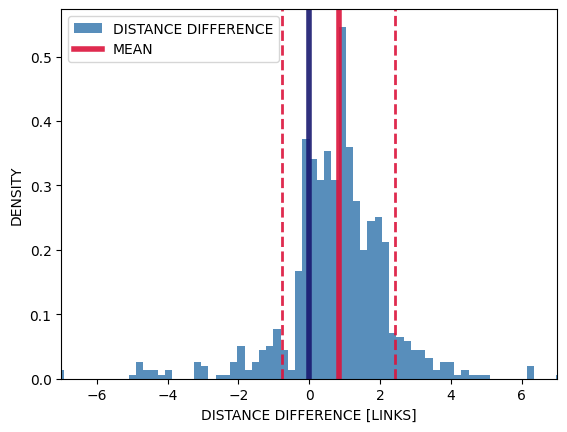

In [562]:
plt.hist(distanceLs, bins = 100, color="steelblue", alpha=0.9, density=True, label="DISTANCE DIFFERENCE")
#plot the mean and the standard deviation
plt.axvline(np.mean(distanceLs), color="crimson", linewidth=4,alpha=0.9, label="MEAN")
plt.axvline(np.mean(distanceLs) + np.std(distanceLs), color="crimson", linewidth=2, linestyle="--", alpha=0.9)
plt.axvline(np.mean(distanceLs) - np.std(distanceLs), color="crimson", linewidth=2, linestyle="--",alpha=0.9)
plt.axvline(0, color="midnightblue", linewidth=4, alpha=0.9)# label="ZERO")
plt.xlim(-7, 7)
plt.legend()
plt.xlabel("DISTANCE DIFFERENCE [LINKS]")
plt.ylabel("DENSITY")
#Save the plot
#plt.savefig("./OUTPUT/DISTANCE_DIFFERENCE_FROM_CONSECUTIVE_FIXATIONS.png", dpi=300)
plt.show()


In [535]:
#Test the significance of the difference with 0
t, p = stats.ttest_1samp(distanceLs, 0)
print("t: ", t)
print("p: ", p)

t:  14.21876862630149
p:  7.333122793597443e-41
